### Final_ML_exam <p/>
#### Anton Ermak

In [2]:
# data wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix, plot_decision_regions
sns.set_theme(style = "whitegrid")

# preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# models
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import LeaveOneOut, cross_validate, GridSearchCV, KFold, train_test_split

# metrics
from sklearn.metrics import mean_squared_error as mse, roc_curve, auc, plot_roc_curve, accuracy_score

import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'mlxtend'


- `Y` - Activity (1 = lying, 2 = sitting, 3 = standing, 4 = walking, 5 = running);

- `X0` — Heart rate;

- `X1-X7` — Data from a monitoring unit on the wrist of the dominant hand;

- `X8-X14` — Data from a monitoring unit on the chest;

- `X5-X21` — Data from a monitoring unit on the dominant side’s ankle

The data from a monitoring unit are: temperature (in degrees celsius), 3D acceleration data (axes $ X, Y, Z, 𝑚/𝑠^2$), 3D-gyroscope data (axes $X, Y, Z, 𝑟𝑎𝑑/𝑠$).
The task is to determine activity type based on the monitoring data.

### Problem #1 <br/> ###


- (1) Read the dataset into computer’s memory. Randomly choose 50% of all the observations for a training sample, and the rest for a test sample, but make sure both contain approximately the same proportions for all activities. (From now on assume that fitting a model means fitting it on the training sample, and testing means testing on the test sample.)

In [ ]:
df = pd.read_csv('activities.txt',
                 sep = "\t|:|,",
                 engine = 'python',
                 na_values = '.')

In [ ]:
df.isna().any().any()
df = df.dropna()

In [5]:
y = df['Y']
X = df.loc[:,'X0':'X21']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1,
                                                        stratify = y, 
                                                        test_size = 0.5)

In [6]:
print(y_train.value_counts())
print(y_test.value_counts())

4    10499
1     8787
3     8628
2     8440
5     4333
Name: Y, dtype: int64
4    10499
1     8788
3     8628
2     8441
5     4332
Name: Y, dtype: int64


(2) Normalize the X0–X21 variables to fit [0, 1].

In [7]:
sc = MinMaxScaler()
sc.fit(X_train)

X_train_sc = pd.DataFrame(sc.transform(X_train), columns = X_train.columns)
X_test_sc = pd.DataFrame(sc.transform(X_test), columns = X_test.columns)

(3) Fit the multinomial logit model, compute the predicted probabilities for test sample data
and form predictions based on maximum predicted probability. Report the probabilities of classification errors. Which variable is the most important in distinguishing walking from running?

In [8]:
def model(method):
    fitted = method.fit(X_train_sc, y_train)
    pred_test = fitted.predict(X_test_sc)
    return fitted, pred_test

def plot_matrix(y_test, y_pred):
    cm1 = confusion_matrix(y_target = y_test, 
                           y_predicted = y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm1,
                                    show_absolute = True,
                                    show_normed = True,
                                    colorbar = True,
                                    cmap = 'Purples')

In [9]:
parameters =  {'penalty': ['l1', 'l2'],
               'alpha': np.geomspace(0.000001, 0.05, 50),
               'random_state':[0],
               'n_jobs': [-1],
               'max_iter':[100]}, 
                           
gs_mlm = GridSearchCV(SGDClassifier(loss = 'log'),
                      parameters, 
                      cv = 5,
                      scoring = 'accuracy', 
                      return_train_score = True)

In [10]:
gs_mlm.fit(X_train_sc, y_train);

In [11]:
gs_mlm.best_params_, gs_mlm.best_score_

({'alpha': 1.764678162208153e-05,
  'max_iter': 100,
  'n_jobs': -1,
  'penalty': 'l2',
  'random_state': 0},
 0.9141004504061121)

In [12]:
alpha = list(gs_mlm.best_params_.values())[0]
penalty = list(gs_mlm.best_params_.values())[3]

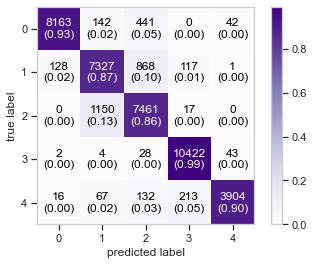

In [13]:
mlm, y_pred = model(SGDClassifier(loss = 'log',
                  alpha = alpha,
                  max_iter = 100,
                  penalty = penalty,
                  random_state = 0,
                  n_jobs = -1))
plot_matrix(y_test, y_pred)

In [14]:
# Which variable is the most important in distinguishing walking from running?
# 1 = lying, 2 = sitting, 3 = standing, 4 = walking, 5 = running
mlm.coef_[3], mlm.coef_[4],

(array([  5.2962575 , -29.90869445, -10.38678138,  -6.31793643,
          7.8123224 ,  -1.93801442,  -2.45017852,   0.81322927,
         39.6154231 ,   1.73444426,   0.56345363,   4.33180047,
         -1.35842499,  -0.46475161,   1.63468719,   0.74495244,
          2.40841908,   1.89486946,   0.51217858,   0.47636426,
         -0.87927203,   0.24261825]),
 array([22.4065154 ,  0.74827881,  2.86031764,  4.75692729, -6.07156202,
         1.29309161,  3.11449483, -1.40732235, -5.79131101, -0.02905962,
         2.44826607, -3.18002408,  0.10654859,  1.09136551, -0.78672817,
        -4.08170551,  4.5421933 ,  4.70591976, -0.79597258,  0.29348461,
        -0.32974269,  0.23363939]))

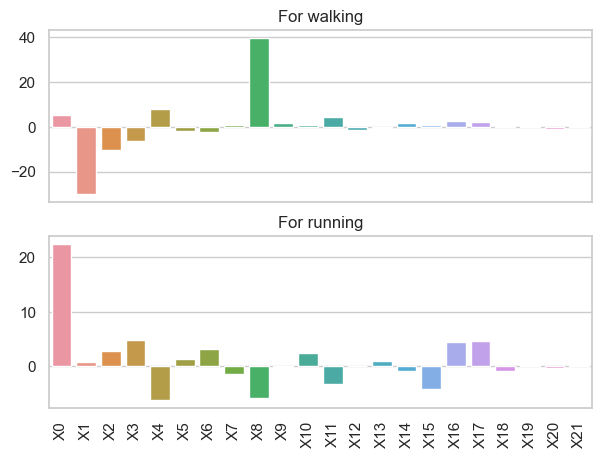

In [15]:
fig, axes = plt.subplots(2, 1, sharex = True, figsize = (7, 5), dpi = 100)
axes[0].set_title('For walking')
axes[1].set_title('For running')
ax = sns.barplot(x = X_train_sc.columns.values.tolist() , y = mlm.coef_[3], ax = axes[0])
ax = sns.barplot(x = X_train_sc.columns.values.tolist() , y = mlm.coef_[4], ax = axes[1])
plt.xticks(rotation = 90);

> Best accuracy score - 0.914 <br/>
X8 is the most important variable for distinguishing walking from running

(4) Construct the random forest classifier using all the available factors, reasonable tree size 𝑇 and some fixed number of features 𝑚 to choose randomly at every branch split, and again produce a classification for the test sample and the probabilities of classification errors. Do that for several values of 𝑇, and then choose the best one using 𝐾-fold cross validation approach (on all the data, not only on a training sample). Can you find the most important feature in distinguishing walking from running?

For T = 3, m = 5

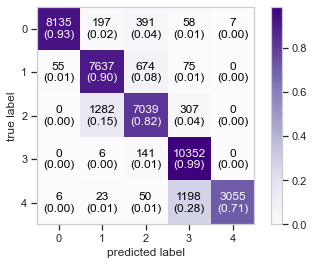

In [16]:
rf, y_pred = model(RandomForestClassifier(n_estimators = 100, 
                            bootstrap = True,
                            max_depth = 3,
                            max_samples = 100,
                            max_features = 5,
                            n_jobs = -1,
                            random_state = 0))
plot_matrix(y_test, y_pred)

For T = 5, m = 5

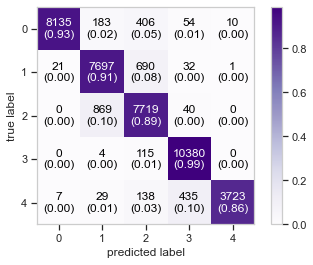

In [17]:
rf, y_pred = model(RandomForestClassifier(n_estimators = 100, 
                            bootstrap = True,
                            max_depth = 5,
                            max_samples = 100,
                            max_features = 5,
                            n_jobs = -1,
                            random_state = 0))
plot_matrix(y_test, y_pred)

For T = 10, m = 5

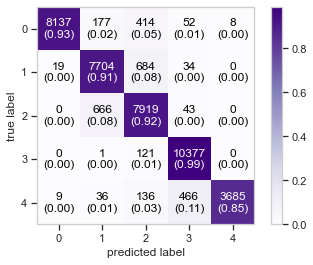

In [18]:
rf, y_pred = model(RandomForestClassifier(n_estimators = 100, 
                            bootstrap = True,
                            max_depth = 10,
                            max_samples = 100,
                            max_features = 5,
                            n_jobs = -1, 
                            random_state = 0))
plot_matrix(y_test, y_pred)

In [19]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [x for x in range(3, 10)],
    'max_features': [5],
    'n_estimators': [100],
    'random_state': [0]
}

gs_rf = GridSearchCV(RandomForestClassifier(), 
                     param_grid = param_grid,
                     cv = 4, 
                     n_jobs = -1, 
                     verbose = 2,
                     return_train_score = True)

In [20]:
sc = MinMaxScaler()
sc.fit(X)

X_sc = pd.DataFrame(sc.transform(X), columns = X.columns)

In [21]:
gs_rf.fit(X_sc, y);

Fitting 4 folds for each of 7 candidates, totalling 28 fits


In [22]:
cv = pd.DataFrame(gs_rf.cv_results_)

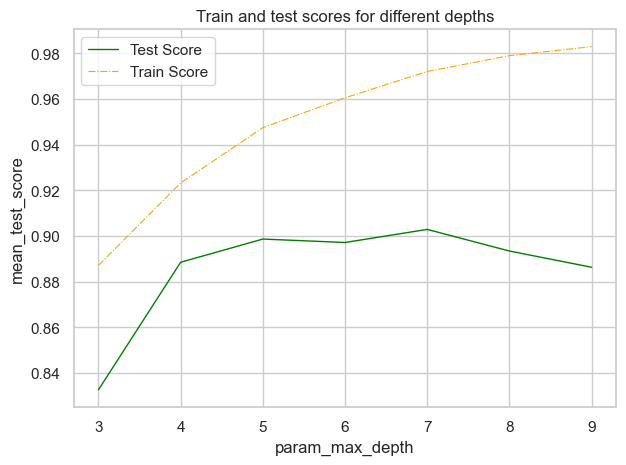

In [23]:
plt.figure(figsize = (7, 5), dpi = 100)
plt.title('Train and test scores for different depths')

sns.lineplot(cv['param_max_depth'], 
             cv['mean_test_score'], 
             color = 'green', lw = 1, linestyle = '-', label = 'Test Score')
sns.lineplot(cv['param_max_depth'], 
             cv['mean_train_score'], 
             color = 'orange', lw = 0.8, linestyle = '-.', label = 'Train Score');

In [24]:
print("Best parameters:", gs_rf.best_params_)
print("Best cross-validation score:", gs_rf.best_score_)

Best parameters: {'bootstrap': True, 'max_depth': 7, 'max_features': 5, 'n_estimators': 100, 'random_state': 0}
Best cross-validation score: 0.9028455846516551


In [25]:
depth = list(gs_rf.best_params_.values())[1]

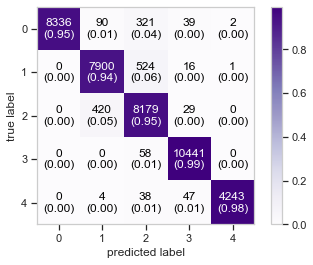

In [26]:
# here train and test
rf_method = RandomForestClassifier(n_estimators = 100, 
                            bootstrap = True,
                            max_depth = depth,
                            max_features = 5,
                            n_jobs = -1,
                            random_state = 0)
rf, y_pred = model(rf_method)
plot_matrix(y_test, y_pred)

> We cannot find the most important feature in random forest, but we can assume, that accuracy of the walking class would be lower without the most important feature, so we can carry out aka Leave one feature out and compare accuracy scores, feature with the minimum accuracy would be the most important.

In [27]:
# only for this, idk why, but this matrix is not the same as from mlxtend.evaluate
from sklearn.metrics import confusion_matrix as conf

def acc(method, x_train, x_test ):
    fitted = method.fit(x_train, y_train)
    pred_test = fitted.predict(x_test)
    cm = confusion_matrix(y_test, pred_test)
    acc = (cm.diagonal()/cm.sum(axis = 1))[3]
    return acc

In [28]:
acc_scores = []
for i in range(0, X_train_sc.shape[1]):
    acc_scores.append(acc(rf_method, 
            X_train_sc.drop(X_train_sc.columns[i], axis = 1),
            X_test_sc.drop(X_test_sc.columns[i], axis = 1)))

In [29]:
acc_scores.index(min(acc_scores))

0

> Best accuracy score - 0.90 <br/>
Variable with index 0 or X0 is the most important variable for distinguishing walking from running

(5) Use all the factors and construct a simple neural network with one hidden layer (try several values for the number of hidden nodes to minimize prediction error), which would distinguish all five activities. Again, report the probabilities of classification errors.

In [30]:
# tensorflow
import tensorflow as tf
from keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import (
    Dense
)

from tensorflow.keras import regularizers

In [31]:
y_train_nn = np.array(pd.get_dummies(pd.Series(y_train), columns = ['Y']))
y_test_nn = np.array(pd.get_dummies(pd.Series(y_test), columns = ['Y']))

In [34]:
def build_nn(n_nodes):
    tf.random.set_seed(0)
    model = Sequential() # create Sequential model - output of the predessesor is an input of the next layer
    # layer wih L1 regularization
    model.add(Dense(n_nodes, input_dim = 22, activation = 'relu', kernel_regularizer = regularizers.l1(0.0001))) 
    # layer with output features - classes of activity status 
    # (1 = lying, 2 = sitting, 3 = standing, 4 = walking, 5 = running)
    model.add(Dense(5, activation = 'softmax')) 

    model.compile(
    optimizer = tf.keras.optimizers.SGD(),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics = [tf.keras.metrics.CategoricalAccuracy()])

    model.fit(X_train_sc, 
              y_train_nn,
              epochs = 10,
              verbose = 0,
              validation_data = (X_test_sc, y_test_nn))
    test_loss, test_acc = model.evaluate(X_test_sc, y_test_nn)
    
    y_pred = model.predict(X_test_sc)
    # code below is needed to convert predictions and test again to 1d arrays (messy but cannot otherwise, sorry)
    pred = []
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))

    test = []
    for i in range(len(y_test_nn)):
        test.append(np.argmax(y_test_nn[i]))
        
    return test_acc, test, pred

In [33]:
scores = [0 for i in range(0, 5)]
nodes = [16, 32, 64, 128, 256]
for i in nodes:
    test_acc, _, _ = build_nn(i)
    scores[nodes.index(i)] = test_acc
    print(f'Number of nodes: {i}, accuracy: {test_acc:.3f}')

2022-04-29 19:49:13.398646: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


[CV] END bootstrap=True, max_depth=3, max_features=5, n_estimators=100, random_state=0; total time=  10.2s
[CV] END bootstrap=True, max_depth=4, max_features=5, n_estimators=100, random_state=0; total time=  13.4s
[CV] END bootstrap=True, max_depth=5, max_features=5, n_estimators=100, random_state=0; total time=  15.0s
[CV] END bootstrap=True, max_depth=6, max_features=5, n_estimators=100, random_state=0; total time=  17.9s
[CV] END bootstrap=True, max_depth=7, max_features=5, n_estimators=100, random_state=0; total time=  18.4s
[CV] END bootstrap=True, max_depth=8, max_features=5, n_estimators=100, random_state=0; total time=  19.6s
[CV] END bootstrap=True, max_depth=9, max_features=5, n_estimators=100, random_state=0; total time=  21.4s
[CV] END bootstrap=True, max_depth=3, max_features=5, n_estimators=100, random_state=0; total time=  10.2s
[CV] END bootstrap=True, max_depth=4, max_features=5, n_estimators=100, random_state=0; total time=  13.4s
[CV] END bootstrap=True, max_depth=5,

In [35]:
scores_df = pd.DataFrame({
    'nodes': nodes,
    'accuracy': scores  
})
best_n = scores_df.loc[scores_df['nodes'].idxmax()]['nodes']

In [36]:
_, test, pred = build_nn(best_n)

1272/1272 [==============================] - 1s 782us/step - loss: 0.2423 - categorical_accuracy: 0.9397


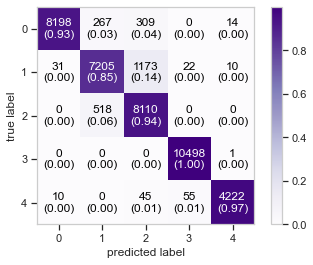

In [37]:
plot_matrix(test, pred)

> Best accuracy score - 0.939 <br/> 

(6) Choose another method of classification yourself, and do the same exercise with the selected method.

In [38]:
param_grid = {
    'bootstrap': [True],   
    'n_estimators': [100],
    'max_samples' : [100],   
    'base_estimator__max_depth': [x for x in range(3, 20)],
    'random_state':[0]   
}

gs_bgg = GridSearchCV(
    BaggingClassifier(base_estimator = DecisionTreeClassifier()),
    param_grid = param_grid,
    verbose = 0,
    scoring = 'accuracy',
    cv = 4,
    return_train_score = True)

In [39]:
gs_bgg.fit(X_train_sc, y_train);

In [40]:
print("Best parameters:", gs_bgg.best_params_)
print("Best score:", gs_bgg.best_score_)

Best parameters: {'base_estimator__max_depth': 8, 'bootstrap': True, 'max_samples': 100, 'n_estimators': 100, 'random_state': 0}
Best score: 0.9238331090650312


In [41]:
depth = list(gs_bgg.best_params_.values())[0]

In [42]:
bgg = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), 
                        n_estimators = 100,        
                        max_samples = 100,    
                        bootstrap = True,     
                        n_jobs = -1,
                        random_state = 0)

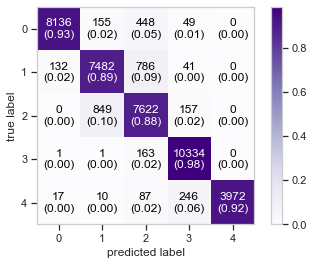

In [43]:
res, y_pred = model(bgg)
plot_matrix(y_test, y_pred)

> Best accuracy score - 0.924 <br/> 

(7) Which of the four prediction methods would you prefer? Why?

> Neural network with one layer shows the best accuracy score (metric of interest), so we decided to use this predicton method